In [34]:
import numpy as np
import pandas as pd
import torch
import zipfile
import bz2
from transformers import DistilBertTokenizer, DistilBertModel
from sklearn.model_selection import train_test_split

# Data

## 1. Twitter

In [4]:
data_path = "../data/"

In [105]:
twitter_zip = zipfile.ZipFile(data_path + "twitter/twitter.zip")
twitter = pd.read_csv(twitter_zip.open('training.1600000.processed.noemoticon.csv'),encoding='ISO-8859-1', header=None)
twitter.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [82]:
y_tw = twitter[0].values
y_tw[y_tw==4]=1
X_tw = twitter[5].values

X_train_val_tw, X_test_tw, y_train_val_tw, y_test_tw = train_test_split(X_tw, y_tw, test_size=0.33, random_state=7)
X_train_tw, X_dev_tw, y_train_tw, y_dev_tw = train_test_split(X_train_val_tw, y_train_val_tw, test_size=0.33, random_state=7)

## 2. Amazon

In [150]:
amazon_train_file = bz2.BZ2File(data_path + 'amazon/train.ft.txt.bz2').readlines()
amazon_test_file = bz2.BZ2File(data_path + 'amazon/test.ft.txt.bz2').readlines()

In [480]:
amazon_train_file = [x.decode('utf-8') for x in amazon_train_file]
amazon_test_file = [x.decode('utf-8') for x in amazon_test_file]

In [481]:
amazon_train_file[0].find(" ")
def get_label_feature_amazon(file):
    labels = []
    reviews = []
    for i, e in enumerate(file):
        sep_pos = e.find(" ")
        label = 1 if e[:sep_pos]=="__label__2" else 0
        review = e[(sep_pos+1):]
        labels.append(label)
        reviews.append(review)
    return np.array(reviews), np.array(labels)

In [482]:
X_train_val_az, y_train_val_az = get_label_feature_amazon(amazon_train_file)
X_test_az, y_test_az = get_label_feature_amazon(amazon_train_file)
X_train_az, X_dev_az, y_train_az, y_dev_az = train_test_split(X_train_val_az, y_train_val_az, test_size=0.33, random_state=7)

In [486]:
sum(y_train_az[:2000])/len(y_train_az[:2000])

0.5095

In [484]:
y_train_az.shape

(2412000,)

## 3. Movie

In [121]:
movie_zip = zipfile.ZipFile(data_path + "movies/movie.zip")

In [127]:
movie_train = pd.read_csv(movie_zip.open('Train.csv'))
movie_dev = pd.read_csv(movie_zip.open('Valid.csv'))
movie_test = pd.read_csv(movie_zip.open('Test.csv'))

In [132]:
X_train_mv = movie_train['text'].values
X_dev_mv = movie_dev['text'].values
X_test_mv = movie_test['text'].values

y_train_mv = movie_train['label'].values
y_dev_mv = movie_dev['label'].values
y_test_mv = movie_test['label'].values

In [133]:
X_train_mv[0], y_train_mv[0]

('I grew up (b. 1965) watching and loving the Thunderbirds. All my mates at school watched. We played "Thunderbirds" before school, during lunch and after school. We all wanted to be Virgil or Scott. No one wanted to be Alan. Counting down from 5 became an art form. I took my children to see the movie hoping they would get a glimpse of what I loved as a child. How bitterly disappointing. The only high point was the snappy theme tune. Not that it could compare with the original score of the Thunderbirds. Thankfully early Saturday mornings one television channel still plays reruns of the series Gerry Anderson and his wife created. Jonatha Frakes should hand in his directors chair, his version was completely hopeless. A waste of film. Utter rubbish. A CGI remake may be acceptable but replacing marionettes with Homo sapiens subsp. sapiens was a huge error of judgment.',
 0)

## 4. Finance

In [157]:
finance_file = pd.read_csv(data_path + "/finance/archive/all-data.csv", encoding='ISO-8859-1', header = None)

In [160]:
finance =  finance_file[finance_file[0]!="neutral"]

In [458]:
y_fi = finance[0].values
y_fi[y_fi=="negative"] = 0
y_fi[y_fi=="positive"] = 1
y_fi = y_fi.astype("int64")
X_fi = finance[1].values

X_train_val_fi, X_test_fi, y_train_val_fi, y_test_fi = train_test_split(X_fi, y_fi, test_size=0.33, random_state=7)
X_train_fi, X_dev_fi, y_train_fi, y_dev_fi = train_test_split(X_train_val_fi, y_train_val_fi, test_size=0.1, random_state=7)

In [459]:
y_train_fi.shape, y_fi.shape # not enough data

((1185,), (1967,))

# Encode

In [7]:
tokenizer_d = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model_d = DistilBertModel.from_pretrained('distilbert-base-uncased')

In [9]:
list(X_train)[:10]

['@Jayme1988 well when you are younger Id agree but as we get older..marrying for money is the way to go ',
 '@Jackalltimelow Awee poor Jack, all alllone! ',
 'my tummy hurts. ',
 'mmmmm pa says my room has to be blue once again  ',
 '@xsameehx wish you were here my love. Our superhero trio is not the same as a duo only ',
 'Watched War of the Worlds. Not bad. Kept seeing Kathy Bates tits flash in my head. ',
 'Just had a really lovely conversation on omegle  I think i made a new friend',
 "@tommcfly tom, isn't your fault, you're still the best ",
 '@catnip070 Caught a cold  cough cough.',
 "@blacksocialite I think we staying at slice... I showed 255 my real I'd "]

In [460]:
def tokenize_encode_sentences(tokenizer, model, input_sentences, output_path):
    output = np.zeros([len(input_sentences), 768])
    for i, x in enumerate(input_sentences): 
        output[i] = tokenize_encode_sentences_sample(tokenizer, model, [x])
    np.save(output_path, output)
    return output

def tokenize_encode_sentences_sample(tokenizer, model, input_sentences):
    encoded_input = tokenizer(input_sentences, return_tensors = 'pt', truncation = True, padding = True)
    output = model(**encoded_input)[0][:,0,:].detach().numpy()
    return output

In [167]:
output_train_tw = tokenize_encode_sentences(tokenizer_d, model_d, list(X_train_tw[:2000]), "../outputs/" + "encoded_twitter_train_2000")
output_dev_tw = tokenize_encode_sentences(tokenizer_d, model_d, list(X_dev_tw[:2000]), "../outputs/" + "encoded_twitter_dev_2000")

In [168]:
output_train_az = tokenize_encode_sentences(tokenizer_d, model_d, list(X_train_az[:2000]), "../outputs/" + "encoded_amazon_train_2000")
output_dev_az = tokenize_encode_sentences(tokenizer_d, model_d, list(X_dev_az[:2000]), "../outputs/" + "encoded_amazon_dev_2000")

In [169]:
output_train_mv = tokenize_encode_sentences(tokenizer_d, model_d, list(X_train_mv[:2000]), "../outputs/" + "encoded_movie_train_2000")
output_dev_mv = tokenize_encode_sentences(tokenizer_d, model_d, list(X_dev_mv[:2000]), "../outputs/" + "encoded_movie_dev_2000")

In [461]:
output_train_fi = tokenize_encode_sentences(tokenizer_d, model_d, list(X_train_fi[:2000]), "../outputs/" + "encoded_finance_train_2000")
output_dev_fi = tokenize_encode_sentences(tokenizer_d, model_d, list(X_dev_fi[:2000]), "../outputs/" + "encoded_finance_dev_2000")

# Models

In [207]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

lr = LogisticRegression(C=0.1, max_iter = 200000)

datasets = ["tw", "az", "mv", "fi"]

def results(model, datasets):
    for s in datasets:
        print(s)
        model.fit(eval("output_train_" + s), eval("y_train_" + s)[:2000])
        s_train = model.score(eval("output_train_" + s), eval("y_train_" + s)[:2000])
        s_val = model.score(eval("output_dev_" + s), eval("y_dev_" + s)[:2000])
        print("source train:", s_train)
        print("source val:", s_val)
        datasets_ts = datasets.copy()
        datasets_ts.remove(s)
        
        for t in datasets_ts:
            t_val = model.score(eval("output_train_" + t), eval("y_train_" + t)[:2000])
            print("target " + t + ":", t_val)
        print()

In [208]:
results(lr, datasets)

tw
source train: 0.8
source val: 0.751
target az: 0.8065
target mv: 0.758
target fi: 0.7721088435374149

az
source train: 0.9015
source val: 0.884
target tw: 0.721
target mv: 0.8185
target fi: 0.8015873015873016

mv
source train: 0.87
source val: 0.8575
target tw: 0.7005
target az: 0.8535
target fi: 0.8344671201814059

fi
source train: 0.8820861678004536
source val: 0.8344827586206897
target tw: 0.711
target az: 0.7675
target mv: 0.7535



# Conclusion:
We can use: 
* tw --> fi
* az --> mv
* az --> fi
* mv --> az
* fi --> az (low priority, bc rarely finance is the source in real world)
* fi --> mv (low priority, bc rarely finance is the source in real world)

# Source to target groups

In [491]:
for data_type in ["az", "tw", "fi", "mv"]:
    exec(data_type + '3000 = np.load("../data/all_bert/encoded_' + data_type + '_train_3000.npy")')

In [243]:
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

In [511]:
def psuedo_labeling(X_source, y_source, X_ti, y_ti, model):  # incorporate alpha in psuedo labeling later
    model = model
    model.fit(X_source, y_source)
    y_pred = model.predict(X_ti)
    X_source_updated = np.concatenate((X_source, X_ti), 0)
    y_source_updated = np.concatenate((y_source, y_pred), 0)
    return X_source_updated, y_source_updated

def gradual_train(X_source, y_source, X_target, y_target, base_model, data_size=2000, group_size=5, plot_hist=True):
    
    # initial model:
    model = base_model
    model.fit(X_source, y_source)
    original = model.score(X_target, y_target)
    
    # calculate distances
    source_center = np.mean(X_source, 0)
    dists = [1 - cosine_similarity(source_center.reshape(1,-1), x.reshape(1, -1))[0][0] for x in X_target]
    if plot_hist:
        plt.hist(dists, bins = 100)
        plt.show()
    
    # create groups within targets and gradually train
    dists = np.array(dists)
    dists_order = np.argsort(dists)
    dists_rank = np.argsort(dists_order)
    
    step = data_size/group_size
    X_target_groups = []
    y_target_groups = []
    X_source_updated = X_source
    y_source_updated = y_source
    for i in range(group_size):
        subset_tf = (step * i <= dists_rank) & (dists_rank < step * (i+1))
        X_ti = X_target[:data_size][subset_tf]
        y_ti = y_target[:data_size][subset_tf]
        X_target_groups.append(X_ti)
        y_target_groups.append(y_ti)
        X_source_updated, y_source_updated = psuedo_labeling(X_source_updated, y_source_updated, X_ti, y_ti, model)
        print(model.fit(X_source_updated, y_source_updated).score(X_target, y_target))
    
    model.fit(X_source_updated, y_source_updated)
    gradual = model.score(X_target, y_target)
    
    return original, gradual

In [524]:
def gradual_train_groups(X_source, y_source, X_target, y_target, base_model, data_size, group_range):
    accuracies = []
    for i in range(group_range[0]+1, group_range[1]+1):
        print("\ngroup = ", i)
        plot_hist = False
        if i==1:
            plot_hist = True
        data_size = data_size
        base_model = base_model
        original, gradual = gradual_train(X_source, y_source, X_target, y_target, 
                                          base_model, data_size=data_size, group_size=i, plot_hist=plot_hist)
        if i==1:
            accuracies.append(original)
        else:
            accuracies.append(gradual)

    plt.plot(accuracies)
    plt.show()


group =  1


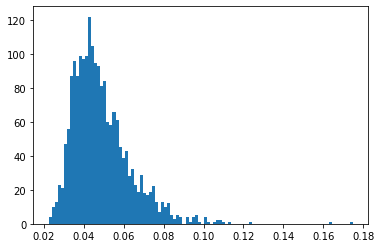

0.815

group =  2
0.82
0.8195

group =  3
0.8185
0.8125
0.811

group =  4
0.8255
0.8175
0.814
0.812

group =  5
0.8215
0.816
0.8145
0.815
0.8135

group =  6
0.8205
0.815
0.8105
0.8105
0.811
0.811

group =  7
0.8235
0.8175
0.8185
0.8165
0.817
0.817
0.8155

group =  8
0.8205
0.811
0.811
0.8075
0.806
0.8075
0.81
0.809

group =  9
0.821
0.8185
0.8165
0.8165
0.8145
0.8115
0.8135
0.814
0.814

group =  10
0.8185
0.816
0.814
0.817
0.816
0.8165
0.812
0.813
0.8125
0.8125


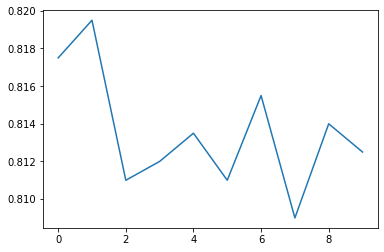

In [516]:
data_size = 2000
base_model = LogisticRegression(max_iter = 200000)
gradual_train_groups(output_train_az[:data_size], y_train_az[:data_size], output_train_mv[:data_size], y_train_mv[:data_size], 
                                      base_model, data_size=data_size, group_range=[0, 10])


group =  1


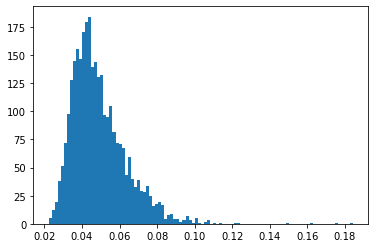

0.8166666666666667

group =  2
0.812
0.8096666666666666

group =  3
0.816
0.8116666666666666
0.8103333333333333

group =  4
0.818
0.8143333333333334
0.8143333333333334
0.8133333333333334

group =  5
0.8173333333333334
0.8156666666666667
0.8103333333333333
0.8093333333333333
0.8093333333333333

group =  6
0.8193333333333334
0.8223333333333334
0.8126666666666666
0.814
0.8086666666666666
0.8076666666666666

group =  7
0.8163333333333334
0.8166666666666667
0.8106666666666666
0.809
0.8076666666666666
0.807
0.8056666666666666

group =  8
0.817
0.815
0.8103333333333333
0.8046666666666666
0.8083333333333333
0.805
0.8046666666666666
0.8043333333333333

group =  9
0.8196666666666667
0.82
0.817
0.81
0.814
0.8106666666666666
0.8083333333333333
0.8066666666666666
0.808

group =  10
0.8213333333333334
0.8213333333333334
0.822
0.818
0.8136666666666666
0.8136666666666666
0.812
0.8063333333333333
0.8046666666666666
0.8056666666666666


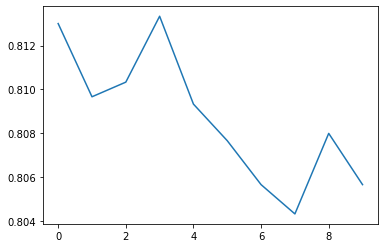

In [526]:
data_size = 3000
base_model = LogisticRegression(max_iter = 200000)
gradual_train_groups(az3000[:data_size], y_train_az[:data_size], mv3000[:data_size], y_train_mv[:data_size], 
                     base_model, data_size=data_size, group_range=[0, 10])


group =  1


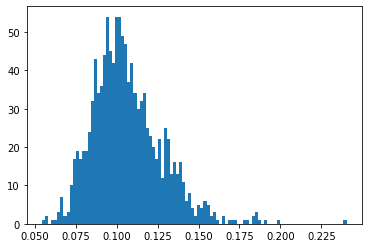

0.810126582278481

group =  2
0.810970464135021
0.810126582278481

group =  3
0.8143459915611815
0.8151898734177215
0.8143459915611815

group =  4
0.8059071729957806
0.8033755274261604
0.8025316455696202
0.8033755274261604

group =  5
0.809282700421941
0.8033755274261604
0.8059071729957806
0.8050632911392405
0.8050632911392405

group =  6
0.810970464135021
0.8067510548523207
0.8042194092827004
0.8033755274261604
0.8025316455696202
0.8025316455696202

group =  7
0.8084388185654009
0.8126582278481013
0.8143459915611815
0.810970464135021
0.8118143459915612
0.8118143459915612
0.8126582278481013

group =  8
0.810126582278481
0.8059071729957806
0.8126582278481013
0.8067510548523207
0.810126582278481
0.8135021097046413
0.8126582278481013
0.8135021097046413

group =  9
0.810970464135021
0.810126582278481
0.8135021097046413
0.810126582278481
0.810970464135021
0.810126582278481
0.809282700421941
0.8075949367088607
0.8075949367088607

group =  10
0.8042194092827004
0.809282700421941
0.80928270042

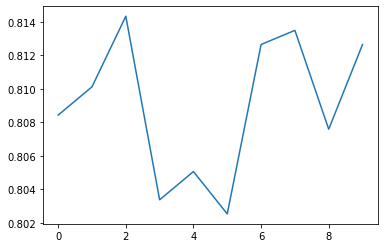

In [529]:
data_size = 1185
base_model = LogisticRegression(max_iter = 200000)
gradual_train_groups(output_train_az[:data_size], y_train_az[:data_size], output_train_fi[:data_size], y_train_fi[:data_size], 
                     base_model, data_size=data_size, group_range=[0, 10])


group =  1


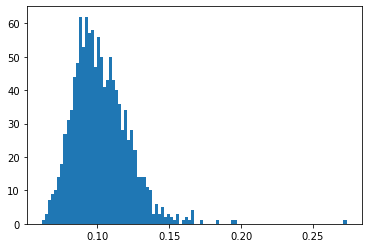

0.7932489451476793

group =  2
0.8
0.8008438818565401

group =  3
0.8059071729957806
0.8050632911392405
0.8059071729957806

group =  4
0.8075949367088607
0.8042194092827004
0.8067510548523207
0.8067510548523207

group =  5
0.7966244725738396
0.7957805907172996
0.7949367088607595
0.7974683544303798
0.7974683544303798

group =  6
0.7890295358649789
0.7864978902953587
0.790717299578059
0.789873417721519
0.7890295358649789
0.7873417721518987

group =  7
0.7924050632911392
0.7890295358649789
0.7924050632911392
0.7949367088607595
0.7949367088607595
0.7949367088607595
0.7949367088607595

group =  8
0.7805907172995781
0.7890295358649789
0.7873417721518987
0.7848101265822784
0.7856540084388186
0.7848101265822784
0.7848101265822784
0.7856540084388186

group =  9
0.7966244725738396
0.8016877637130801
0.8042194092827004
0.8016877637130801
0.8008438818565401
0.8016877637130801
0.8016877637130801
0.8025316455696202
0.8025316455696202

group =  10
0.7924050632911392
0.8
0.8042194092827004
0.803375527

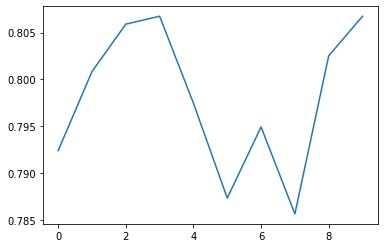

In [530]:
data_size = 1185
base_model = LogisticRegression(max_iter = 200000)
gradual_train_groups(output_train_fi[:data_size], y_train_fi[:data_size], output_train_az[:data_size], y_train_az[:data_size], 
                     base_model, data_size=data_size, group_range=[0, 10])


group =  1


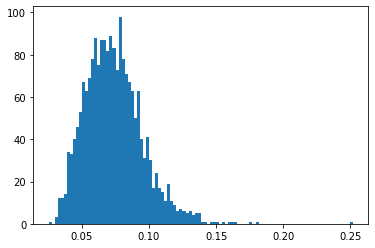

0.7875

group =  2
0.783
0.7845

group =  3
0.782
0.782
0.784

group =  4
0.782
0.7845
0.7845
0.785

group =  5
0.7755
0.7735
0.7745
0.773
0.7725

group =  6
0.773
0.7745
0.7715
0.7695
0.7695
0.7695

group =  7
0.7795
0.7835
0.7825
0.782
0.7845
0.784
0.7835

group =  8
0.779
0.777
0.7745
0.774
0.772
0.7695
0.7695
0.7695

group =  9
0.7795
0.781
0.775
0.7765
0.776
0.7795
0.7745
0.774
0.7755

group =  10
0.7775
0.7765
0.777
0.7755
0.7725
0.7715
0.771
0.7725
0.7715
0.773


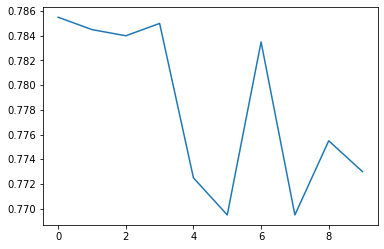

In [531]:
data_size = 2000
base_model = LogisticRegression(max_iter = 200000)
gradual_train_groups(output_train_tw[:data_size], y_train_tw[:data_size], output_train_az[:data_size], y_train_az[:data_size], 
                     base_model, data_size=data_size, group_range=[0, 10])


group =  1


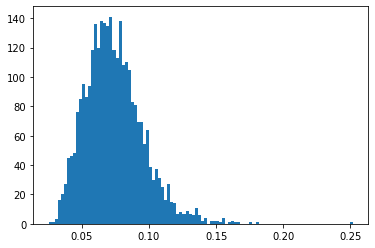

0.7756666666666666

group =  2
0.7713333333333333
0.77

group =  3
0.7743333333333333
0.7746666666666666
0.775

group =  4
0.7786666666666666
0.7733333333333333
0.775
0.7753333333333333

group =  5
0.7773333333333333
0.7743333333333333
0.7723333333333333
0.7713333333333333
0.7726666666666666

group =  6
0.7743333333333333
0.775
0.7723333333333333
0.7713333333333333
0.7716666666666666
0.773

group =  7
0.772
0.773
0.772
0.773
0.7716666666666666
0.771
0.7713333333333333

group =  8
0.7706666666666667
0.7786666666666666
0.777
0.776
0.7763333333333333
0.7756666666666666
0.7753333333333333
0.7756666666666666

group =  9
0.7656666666666667
0.774
0.7733333333333333
0.7716666666666666
0.772
0.7703333333333333
0.77
0.77
0.7696666666666667

group =  10
0.7626666666666667
0.7623333333333333
0.764
0.7633333333333333
0.762
0.7626666666666667
0.7633333333333333
0.7616666666666667
0.763
0.7613333333333333


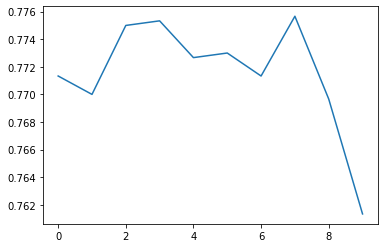

In [532]:
data_size = 3000
base_model = LogisticRegression(max_iter = 200000)
gradual_train_groups(tw3000[:data_size], y_train_tw[:data_size], az3000[:data_size], y_train_az[:data_size], 
                     base_model, data_size=data_size, group_range=[0, 10])

## checking v1

In [395]:
az_bert = np.mean(output_train_az,0)
dists = []
for e in output_train_mv:
    dist = 1- cosine_similarity(az_bert.reshape(1, -1), e.reshape(1, -1))[0][0]
    dists.append(dist)

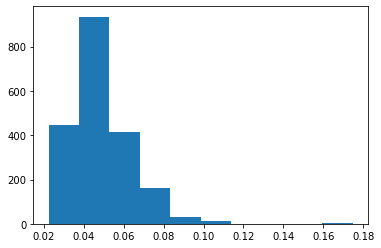

In [396]:
plt.hist(dists)
plt.show()

In [412]:
dists = np.array(dists)
dists_order = np.argsort(dists)
dists_rank = np.argsort(dists_order)

step = 2000/5
target_x = []
target_y = []

for i in range(5):
    subset_tf = (step*i <= dists_rank) & (dists_rank < step* (i+1))
    t_x = output_train_mv[subset_tf]
    t_y = y_train_mv[:2000][subset_tf]
    target_x.append(t_x)
    target_y.append(t_y)
    
print(dists_rank[892])
print(dists[892])

0
0.02226760322709498


In [444]:
lr = LogisticRegression(max_iter = 200000)
lr.fit(output_train_az, y_train_az[:2000])
print("Train:")
print(lr.score(output_train_az, y_train_az[:2000]), "\n")
print("Val:")
print(lr.score(output_train_mv, y_train_mv[:2000]))


y_pred = lr.predict(target_x[0])
X_train_az_t1 = np.concatenate((output_train_az, target_x[0]), 0)
y_train_az_t1 = np.concatenate((y_train_az[:2000], y_pred), 0)
lr.fit(X_train_az_t1, y_train_az_t1)
print(lr.score(output_train_mv, y_train_mv[:2000]))


y_pred = lr.predict(target_x[1])
X_train_az_t1t2 = np.concatenate((X_train_az_t1, target_x[1]), 0)
y_train_az_t1t2 = np.concatenate((y_train_az_t1, y_pred), 0)
lr.fit(X_train_az_t1t2, y_train_az_t1t2)
print(lr.score(output_train_mv, y_train_mv[:2000]))

y_pred = lr.predict(target_x[2])
X_train_az_t1t2t3 = np.concatenate((X_train_az_t1t2, target_x[2]), 0)
y_train_az_t1t2t3 = np.concatenate((y_train_az_t1t2, y_pred), 0)
lr.fit(X_train_az_t1t2t3, y_train_az_t1t2t3)
print(lr.score(output_train_mv, y_train_mv[:2000]))

y_pred = lr.predict(target_x[3])
X_train_az_t1t2t3t4 = np.concatenate((X_train_az_t1t2t3, target_x[3]), 0)
y_train_az_t1t2t3t4 = np.concatenate((y_train_az_t1t2t3, y_pred), 0)
lr.fit(X_train_az_t1t2t3t4, y_train_az_t1t2t3t4)
print(lr.score(output_train_mv, y_train_mv[:2000]))


y_pred = lr.predict(target_x[4])
X_train_az_t1t2t3t4t5 = np.concatenate((X_train_az_t1t2t3t4, target_x[4]), 0)
y_train_az_t1t2t3t4t5 = np.concatenate((y_train_az_t1t2t3t4, y_pred), 0)
lr.fit(X_train_az_t1t2t3t4t5, y_train_az_t1t2t3t4t5)
print(lr.score(output_train_mv, y_train_mv[:2000]))

Train:
0.9315 

Val:
0.8175
0.8215
0.816
0.8145
0.815
0.8135


## checking v2

In [430]:
# from Young-Min with some edits

def S2T(train_features, train_labels, test_features, test_labels):
    lr_clf = LogisticRegression(max_iter = 200000) #edited 
    lr_clf.fit(train_features, train_labels)
    return lr_clf.score(test_features, test_labels)

def cos_dist(A, B):
       return 1 - (np.dot(A, B)/(np.linalg.norm(A)*np.linalg.norm(B)))
    
def S2ti(train_features, train_labels, test_features, test_labels):
    print("train.shape: ",train_labels.shape)
    print("test.shape: ",test_labels.shape)    
    source_center = np.mean(train_features, 0)
    target_distances = [1-cosine_similarity(source_center.reshape(1,-1), x.reshape(1, -1))[0][0] for x in test_features] #edited
    print("histogram of distance:")
    plt.hist(target_distances)
    plt.show()
    target_distances = [(i,x) for i,x in enumerate(target_distances)]
    target_distances = sorted(target_distances, key=lambda x: x[1])
    one_fifth = int(len(target_distances)/5)
    target_1in5 = target_distances[:one_fifth]
    target_2in5 = target_distances[one_fifth:2*one_fifth]
    target_3in5 = target_distances[2*one_fifth:3*one_fifth]
    target_4in5 = target_distances[3*one_fifth:4*one_fifth]
    target_5in5 = target_distances[4*one_fifth:]
    X_train = train_features[:]
    y_train = train_labels[:]
    y_pred_store = []
    y_test_store = []
    for target in [target_1in5,target_2in5,target_3in5,target_4in5,target_5in5]:
        X_test = [test_features[i] for i,x in target]
        y_test = [test_labels[i] for i,x in target]
        lr_clf = LogisticRegression(max_iter = 200000) #edited 
        lr_clf.fit(X_train, y_train)
        y_pred = lr_clf.predict(X_test)
        X_train = np.concatenate((X_train, X_test), axis=0)
        y_train = np.concatenate((y_train, y_pred), axis=0)
        y_pred_store += y_pred.tolist()
        y_test_store += y_test
    output_score = [y_pred_store[i]==y_test_store[i] for i in range(len(y_test_store))]
    gradual_score = sum(output_score)/len(output_score)
    original_score = S2T(train_features, train_labels, test_features, test_labels)
    return original_score, gradual_score

train.shape:  (2000,)
test.shape:  (2000,)
histogram of distance:


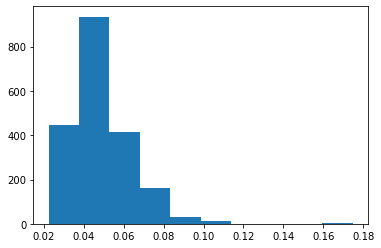

(0.8175, 0.813)

In [431]:
S2ti(output_train_az, np.array(y_train_az[:2000]), 
     output_train_mv, np.array(y_train_mv[:2000]))